In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [31]:
df = pd.read_csv('data/cleaned_rounds_data_with_stats.csv')
df.head()

,round_winner,team_1_position,team_1_win_percentage,team_2_position,team_2_win_percentage,player_1_team_name,player_1_name,player_1_rating,player_1_kills_per_round,player_1_headshots,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,0,1,1,0,0
1,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,1,1,0,0
2,0,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,0,1,0,0
3,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,0,1,0,0
4,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,1,1,0,0


In [32]:
df = df.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
df.head()

,round_winner,team_1_position,team_1_win_percentage,team_2_position,team_2_win_percentage,player_1_rating,player_1_kills_per_round,player_1_headshots,player_1_deaths_per_round,player_1_rounds_contributed,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,0,1,1,0,0
1,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,1,1,0,0
2,0,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,0,1,0,0
3,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,0,1,0,0
4,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,1,1,0,0


In [33]:
df['round_winner'].count()

11686

In [34]:
def sigmoid(z):
    """Numerically stable sigmoid function."""
    z = np.clip(z, -500, 500)  # Limit z to avoid overflow
    return np.where(z >= 0,
                    1 / (1 + np.exp(-z)),
                    np.exp(z) / (1 + np.exp(z)))

In [35]:
def cross_entropy(y, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [36]:
def compute_gradients(X, y, y_pred):
    diff = y_pred - y
    return np.dot(X.T, diff) / len(y)

In [37]:
def initialize_weights(size):
    std_dev = np.sqrt(2 / (size + 1))
    return np.random.randn(size) * std_dev

In [39]:
def logistic_regression(X, y, lr, epochs, e=1e-6):
    w = initialize_weights(X.shape[1])
    losses = []
    for epoch in range(epochs):
        z = np.dot(X, w)
        y_pred = sigmoid(z)
        loss = cross_entropy(y, y_pred)
        gradients = compute_gradients(X, y, y_pred)
        w -= lr * gradients
        new_loss = cross_entropy(y, sigmoid(np.dot(X, w)))
        losses.append(new_loss)
        if epoch % 250 == 0:
            print(f'Epoch {epoch}, loss {loss}')
        if np.abs(new_loss - loss) < e:
            print(np.abs(new_loss - loss))
            print(f'Converged at epoch {epoch}')
            break
    return w, losses

In [40]:
def predict(X, w, threshold=0.5):
    z = np.dot(X, w)
    probabilities = sigmoid(z)
    return (probabilities >= threshold).astype(int)

In [41]:
X = df.drop(['round_winner'], axis=1)
X.head()

,team_1_position,team_1_win_percentage,team_2_position,team_2_win_percentage,player_1_rating,player_1_kills_per_round,player_1_headshots,player_1_deaths_per_round,player_1_rounds_contributed,player_1_team_num,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,0,1,1,0,0
1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,1,1,0,0
2,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,0,1,0,0
3,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,0,1,0,0
4,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,1,1,0,0


In [43]:
y = df['round_winner']

In [42]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [44]:
X[1]

array([ 0.37209471, -0.49367789, -0.39153782,  0.18199044,  0.89382724,
        0.61671211,  0.2237378 , -0.04739018,  0.28746283, -1.02215185,
       -1.08922427, -1.01729983, -0.47130591,  0.70964969,  0.45272124,
       -0.06507311, -0.75110378, -0.6718009 , -0.48212075, -0.16886713,
       -0.34048229, -0.0292653 , -0.02448196, -0.10971672,  4.290916  ,
       -0.00925094,  0.        , -0.01850425, -0.0571171 , -0.00925094,
       -0.14603062, -0.02617344, -0.20606331,  0.        ,  0.        ,
        0.        , -0.01602446, -0.02617344,  0.        , -0.01308336,
       -0.19850011, -0.76567817,  1.28611799, -0.19020154, -0.18899061,
       -0.23467858, -0.04440775, -0.2495337 ,  0.        , -0.1432558 ,
        0.53361086, -1.00738651,  0.68605909, -0.66617229,  1.44932991,
       -0.049008  , -0.48766715, -0.08363342,  0.94025439,  0.32860502,
       -0.65062045,  1.01222602, -0.5901575 , -1.23842167, -0.44629482,
        0.6865987 ,  0.44411564, -0.05959735, -0.77259167, -0.68

In [45]:
lr = 0.1
epochs = 10000

In [46]:
w, losses = logistic_regression(X, y, lr, epochs)

Epoch 0, loss 0.8820832759663831
Epoch 250, loss 0.4888298525954224
Epoch 500, loss 0.48704204483856234
Epoch 750, loss 0.48650832093786567
9.989508503727151e-07
Converged at epoch 936


In [47]:
print(f"Weights: {w}")

Weights: [ 2.55447444e-02  1.68699490e-02 -1.16550128e-02 -1.33104919e-02
 -3.11909749e-02  7.38104634e-02 -3.35245888e-02 -3.02997706e-02
 -2.68318916e-02  3.66969284e-02 -1.41648141e-02  6.88797017e-03
  1.88876342e-01  9.83174748e-02  4.28177927e-02 -8.17563730e-02
  4.13017729e-02 -2.14592589e-02 -3.10335801e-02  4.38541391e-02
 -1.09931056e-01 -1.16922150e-02 -7.30217966e-03  4.82182809e-02
 -7.04221938e-02  3.00111468e-02  1.38176014e-03 -5.05423112e-02
  2.70548418e-02 -6.64215332e-02  9.75609205e-03 -5.20733909e-02
  3.09799312e-02 -5.36911141e-02 -9.25740094e-02 -4.02550064e-02
 -5.90301459e-02  1.60179398e-02 -3.58129844e-02  9.81512010e-02
 -1.93735878e-02  4.17545964e-02  1.47167313e-01 -5.37113783e-03
 -3.60654715e-02  4.82252677e-02 -2.08369155e-02  1.13892385e-02
  8.54749397e-02  5.11692029e-02 -6.70741795e-02 -5.26385650e-02
 -8.66066261e-03  1.47568915e-01 -1.57011135e-01 -4.15001415e-02
 -5.92230948e-03 -9.43962754e-03  7.16972630e-02 -7.10742540e-02
  1.53061654e-02

Text(0, 0.5, 'Loss')

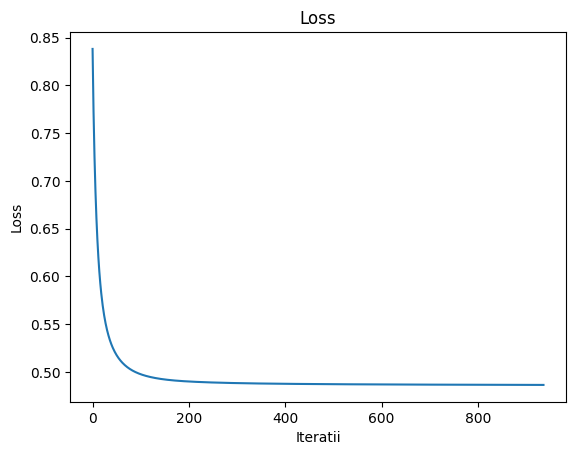

In [48]:
plt.title("Loss")
plt.plot(losses)
plt.xlabel("Iteratii")
plt.ylabel("Loss")

In [49]:
y_pred = predict(X, w)

In [50]:
print(classification_report(y, y_pred))
confusion_matrix = metrics.confusion_matrix(y, y_pred)
conf_matrix_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'],
                              columns=['Predicted Negative', 'Predicted Positive'])
print(conf_matrix_df)

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      5739
           1       0.77      0.81      0.79      5947

    accuracy                           0.78     11686
   macro avg       0.78      0.78      0.78     11686
weighted avg       0.78      0.78      0.78     11686

                 Predicted Negative  Predicted Positive
Actual Negative                4327                1412
Actual Positive                1158                4789
